<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/1.1_CMV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install netCDF4

In [2]:
# Verbinden mit der Google-Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import io, os, sys, setuptools, tokenize

In [4]:
## import modules

import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt

from datetime import datetime
from datetime import timedelta
from prophet import Prophet
from itertools import product

from scipy.fft import fft

In [5]:
# Zeit wird in Stunden seit 1.1.1900 00:00 angegeben
origin = dt.datetime(1900, 1, 1, 0, 0, 0, 0)

In [36]:
latitude_station = 50.2
longitude_station = 7.8

In [7]:
# Drive Ordner mit den Vorhersagewerten im NetCDF4-Format
drive_folder = '/content/drive/My Drive/Colab_Notebooks/netCDF4_CloudCover/'
drive_name = 'CloudCover.nc'

In [8]:
def read_nc_files_in_google_drive(folder_path, file_name):
  nc_files = []  # Liste, um die NetCDF4-Datensätze abzuspeichern

  if os.path.exists(folder_path):
    file_path = os.path.join(folder_path, file_name)
    # Öffnen der NetCDF4-Datei und huzfügen zur Liste
    nc_file = nc.Dataset(file_path, mode = 'r')
    print(nc_file)

  return nc_file

In [9]:
# Funktionsaufruf zum Einlesen der NetCDF4-Dateien
netcdf_files = read_nc_files_in_google_drive(drive_folder, drive_name)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2024-01-27 01:18:30 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/tmp/cf67f0b7-009c-4701-8a2c-4cceb74c126d-adaptor.mars_constrained.external-1706318287.9226196-13905-16-tmp.nc /cache/tmp/cf67f0b7-009c-4701-8a2c-4cceb74c126d-adaptor.mars_constrained.external-1706318282.4361563-13905-15-tmp.grib
    dimensions(sizes): longitude(26), latitude(26), time(9504)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 tcc(time, latitude, longitude)
    groups: 


In [10]:
netcdf_files

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2024-01-27 01:18:30 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/tmp/cf67f0b7-009c-4701-8a2c-4cceb74c126d-adaptor.mars_constrained.external-1706318287.9226196-13905-16-tmp.nc /cache/tmp/cf67f0b7-009c-4701-8a2c-4cceb74c126d-adaptor.mars_constrained.external-1706318282.4361563-13905-15-tmp.grib
    dimensions(sizes): longitude(26), latitude(26), time(9504)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 tcc(time, latitude, longitude)
    groups: 

In [11]:
latitudes = np.array(netcdf_files.variables['latitude'][:].reshape(-3))
longitudes = np.array(netcdf_files.variables['longitude'][:].reshape(-3))
time = np.array(netcdf_files.variables['time'][:].filled(np.nan))
tcc = np.array(netcdf_files.variables['tcc'][:].filled(np.nan).reshape(-3))

In [12]:
print(latitudes, longitudes, time, tcc)

[55.  54.6 54.2 53.8 53.4 53.  52.6 52.2 51.8 51.4 51.  50.6 50.2 49.8
 49.4 49.  48.6 48.2 47.8 47.4 47.  46.6 46.2 45.8 45.4 45. ] [ 2.   2.4  2.8  3.2  3.6  4.   4.4  4.8  5.2  5.6  6.   6.4  6.8  7.2
  7.6  8.   8.4  8.8  9.2  9.6 10.  10.4 10.8 11.2 11.6 12. ] [1072320 1072321 1072322 ... 1081821 1081822 1081823] [1.00000763 0.98340518 0.98160455 ... 0.24621371 0.21612177 0.18410712]


In [13]:
# richtige DateTime berechen
datetime = np.empty((1,1))
datetime = np.array([origin + dt.timedelta(hours=int(i)) for i in time])

In [14]:
df_tcc = pd.DataFrame(index=datetime)

In [15]:
coords = list(product(longitudes, latitudes))

In [16]:
cloud_data_reshaped = tcc.reshape(-1, tcc.shape[-1])

In [17]:
columns = ['Longitude', 'Latitude'] + [f'Time_{i}' for i in range(tcc.shape[-1])]
data = []

In [18]:
multi_index = pd.MultiIndex.from_product([datetime, coords], names=["datetime", "coords"])

In [22]:
multi_index

MultiIndex([('2022-05-01 00:00:00',  (2.0, 55.0)),
            ('2022-05-01 00:00:00',  (2.0, 54.6)),
            ('2022-05-01 00:00:00',  (2.0, 54.2)),
            ('2022-05-01 00:00:00',  (2.0, 53.8)),
            ('2022-05-01 00:00:00',  (2.0, 53.4)),
            ('2022-05-01 00:00:00',  (2.0, 53.0)),
            ('2022-05-01 00:00:00',  (2.0, 52.6)),
            ('2022-05-01 00:00:00',  (2.0, 52.2)),
            ('2022-05-01 00:00:00',  (2.0, 51.8)),
            ('2022-05-01 00:00:00',  (2.0, 51.4)),
            ...
            ('2023-05-31 23:00:00', (12.0, 48.6)),
            ('2023-05-31 23:00:00', (12.0, 48.2)),
            ('2023-05-31 23:00:00', (12.0, 47.8)),
            ('2023-05-31 23:00:00', (12.0, 47.4)),
            ('2023-05-31 23:00:00', (12.0, 47.0)),
            ('2023-05-31 23:00:00', (12.0, 46.6)),
            ('2023-05-31 23:00:00', (12.0, 46.2)),
            ('2023-05-31 23:00:00', (12.0, 45.8)),
            ('2023-05-31 23:00:00', (12.0, 45.4)),
            ('2

In [24]:
df_tcc = pd.DataFrame(tcc, index=multi_index, columns=["tcc"])

In [25]:
df_tcc

tcc
datetime            coords                
2022-05-01 00:00:00 (2.0, 55.0)   1.000008
                    (2.0, 54.6)   0.983405
                    (2.0, 54.2)   0.981605
                    (2.0, 53.8)   0.853729
                    (2.0, 53.4)   0.663335
...                                    ...
2023-05-31 23:00:00 (12.0, 46.6)  0.048037
                    (12.0, 46.2)  0.152428
                    (12.0, 45.8)  0.246214
                    (12.0, 45.4)  0.216122
                    (12.0, 45.0)  0.184107

[6424704 rows x 1 columns]

## Plotten der Bewölkungsdaten:

In [28]:
specific_time = df_tcc.index.get_level_values('datetime')[0]
df_filtered = df_tcc.loc[specific_time]

In [32]:
coordinates = df_filtered.index.get_level_values('coords')
latitudes = np.array([coord[0] for coord in coordinates])
longitudes = np.array([coord[1] for coord in coordinates])
cloud_values = df_filtered['tcc'].values.reshape(len(np.unique(latitudes)), len(np.unique(longitudes)))

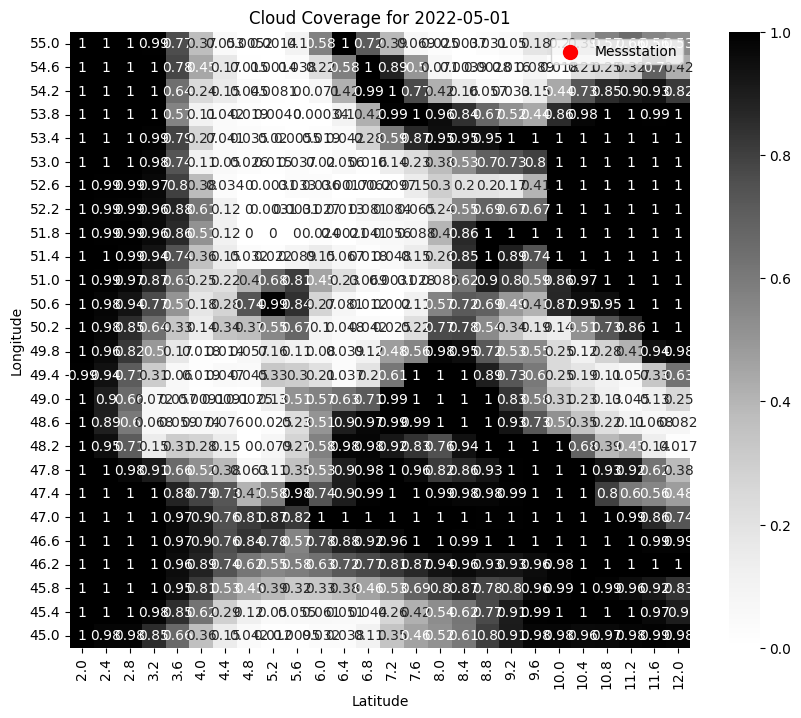

In [46]:
plt.figure(figsize=(10, 8))
sns.heatmap(cloud_values, xticklabels=np.unique(latitudes), yticklabels=np.unique(longitudes), cmap='Greys', annot=True)
plt.title(f'Cloud Coverage for {specific_time.strftime("%Y-%m-%d")}')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

plt.scatter(latitude_station, longitude_station, color='red', s=100, label='Messstation', zorder=5)

plt.gca().invert_yaxis()

plt.legend()

plt.show()